# Comparison of different ZNE fitting methods

- Weighted-least squares (WLS)
- Ordinary-least squares (OLS)
- Bootstrapping (the mean of which will be the OLS result)

In [23]:
import os

import json
import numpy as np
from matplotlib import pyplot as plt
from symmer.symplectic import PauliwordOp, QuantumState
from symmer.utils import exact_gs_energy

qem_directory =  os.getcwd()
print(qem_directory)
ham_data_dir = os.path.join(qem_directory, 'data/hamiltonian')
qem_data_dir = os.path.join(qem_directory, 'data/QEM_benchmark')

filename = 'HCl_STO-3G_SINGLET_JW.json'
    
with open(os.path.join(ham_data_dir, filename), 'r') as infile:
    data_dict = json.load(infile)

hf_energy = data_dict['data']['calculated_properties']['HF']['energy']
mp2_energy = data_dict['data']['calculated_properties']['MP2']['energy']
ccsd_energy = data_dict['data']['calculated_properties']['CCSD']['energy']
fci_energy = data_dict['data']['calculated_properties']['FCI']['energy']

####### Contextual Subspace Hamiltonian #######

ham_cs_dict = {'III': (-453.09074243348186+0j), 'IIZ': (0.3938279139008882+0j), 'IZI': (0.6207540014723985+0j), 'IZZ': (0.8467205227384085+0j), 'ZII': (0.6207540014723985+0j), 'ZIZ': (0.8467205227384084+0j), 'ZZI': (0.2583692120830724+0j), 'ZZZ': (0.23804868510762295+0j), 'IIX': (-0.015457549840655714+0j), 'IZX': (0.015457549840655714-0j), 'ZIX': (0.015457549840655714+0j), 'ZZX': (-0.015457549840655714+0j), 'IXI': (0.004504380403727218+0j), 'IXZ': (-0.004504380403727218+0j), 'ZXI': (0.06195857194191802+0j), 'ZXZ': (-0.06195857194191802+0j), 'IXX': (-0.009644441995559343+0j), 'IYY': (-0.009644441995559343+0j), 'ZXX': (0.009644441995559343+0j), 'ZYY': (0.009644441995559343+0j), 'XII': (-0.004504380403727218+0j), 'XIZ': (0.004504380403727218+0j), 'XZI': (-0.06195857194191803+0j), 'XZZ': (0.061958571941918006+0j), 'XIX': (0.009644441995559343+0j), 'XZX': (-0.009644441995559343+0j), 'YIY': (0.009644441995559343-0j), 'YZY': (-0.009644441995559343+0j), 'YYI': (-0.05559874279713038+0j), 'YYZ': (0.05559874279713038+0j), 'XXX': (-0.03521948529328592+0j), 'XYY': (-0.03521948529328592+0j), 'YXY': (-0.03521948529328592+0j), 'YYX': (0.03521948529328592-0j)}
num_op_cs_dict = {'III': (17+0j), 'IIZ': (-1+0j), 'IZI': (-0.5+0j), 'IZZ': (-0.5+0j), 'ZII': (-0.5+0j), 'ZIZ': (-0.5+0j)}
spin_op_cs_dict = {'IZI': (0.25+0j), 'IZZ': (0.25-0j), 'ZII': (-0.25+0j), 'ZIZ': (-0.25+0j)}

ham_cs = PauliwordOp.from_dictionary(ham_cs_dict)
num_op_cs = PauliwordOp.from_dictionary(num_op_cs_dict)
spin_op_cs = PauliwordOp.from_dictionary(spin_op_cs_dict)
# true ground state
psi_array = np.array(
    [
        [-3.92075303e-03+0.j],
        [ 1.16802197e-01+0.j],
        [ 1.53814406e-05+0.j],
        [-3.17010388e-02+0.j],
        [-6.70251842e-06+0.j],
        [ 3.17077325e-02+0.j],
        [ 9.91827641e-01+0.j],
        [ 2.46874043e-02+0.j]
    ]
)

true_energy = fci_energy - ham_cs.coeff_vec[0]

print(true_energy)

/home/tweaving/qc-research/quantum-error-mitigation
(-2.0663243596669645+0j)


In [24]:
systems = {
    'ibmq_montreal':{'threshold':0.38, 'threshold_2':0.17},
    'ibmq_kolkata':{'threshold':0.5, 'threshold_2':0.33},
    'ibmq_mumbai':{'threshold':0.08, 'threshold_2':0.72},
    'ibm_auckland':{'threshold':0.47, 'threshold_2':0.82},
    'ibm_cairo':{'threshold':0.5, 'threshold_2':0.22},
    'ibm_hanoi':{'threshold':0.24, 'threshold_2':0.85},
    'ibmq_toronto':{'threshold':0.76, 'threshold_2':0.98},
    'ibm_geneva':{'threshold':0.39, 'threshold_2':0.16}
}

In [25]:
from copy import deepcopy
from postprocessing.zne_tools import *
from postprocessing.dsp_tools import *
from postprocessing.process_HCl_experiments import get_data, update_data, zero_noise_extrapolation

In [63]:
hamiltonian = ham_cs[1:]

zne_data_to_plot = {}

for system in systems:
    print(system)
    data_raw, data_zne, data_dsp, data_dsp_zne = get_data(system)
    sym_corrected_data_zne = deepcopy(data_zne)
    for i in data_zne['results']['ZNE_factors']:
        update_data(sym_corrected_data_zne, use='MEM', noise_amp=i)
    out = zero_noise_extrapolation(
        sym_corrected_data_zne, 
        hamiltonian.coeff_vec, 
        use='MEM', 
        n_resamples=100
    )
    zne_data_to_plot[system] = out 

ibmq_montreal
ibmq_kolkata
ibmq_mumbai
ibm_auckland
ibm_cairo
ibm_hanoi
ibmq_toronto
ibm_geneva


In [79]:
def plot_zne_data(out, ax, system):

    bs_noisy_estimates = np.sum(out['raw_data'].T * hamiltonian.coeff_vec.reshape(1,33,1), axis=1)
    bs_zne_curves = [np.poly1d(np.polyfit([1,2,3,4], y, deg=1)) for y in bs_noisy_estimates]

    for c in bs_zne_curves:
        ax.plot(c([0,1,2,3,4]), alpha=0.2, color='blue', lw=0.2, zorder=1)

    x = out['lambdas']
    y = out['noisy_estimates']
    w = out['noisy_variances']

    f_wls = out['WLS']['curve']
    f_ols = out['OLS']['curve']

    zne_var = out['WLS']['variance']
    #print(out['WLS']['rsquared'], zne_var)

    l = np.append(0, x)

    ax.plot([0],[true_energy], alpha=1, color='blue', lw=1, label='Bootstrapped best fits', zorder=2)
    ax.errorbar(x, y, yerr=np.sqrt(w), capsize=4, ls='', color='orange', label='Noisy estimates')
    ax.plot(l, f_ols(l), color='cyan', label='Ordinary least squares', zorder=2)
    ax.plot(l, f_wls(l), color='teal', label='Weighted least squares', zorder=2)
    ax.hlines(true_energy, 0, 4, color='green', ls=':', label='FCI')
    
    bias_wls = 1e3*(out['WLS']['estimate']-true_energy).real
    bias_ols = 1e3*(out['OLS']['estimate']-true_energy).real
    
    #print(out['WLS']['rsquared'], out['OLS']['rsquared'])
    ax.text(0.08, 0.88, f'WLS bias = {bias_wls:.1f}', transform=ax.transAxes)
    ax.text(0.08, 0.78, f'OLS bias = {bias_ols:.1f}', transform=ax.transAxes)
    
    ax.set_title(system)
    #ax.legend()

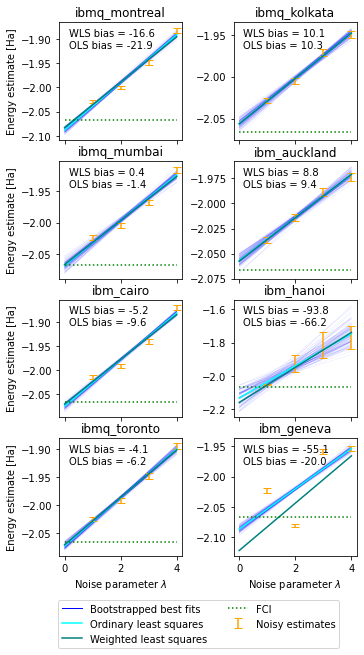

In [81]:
fig, axes = plt.subplots(4,2,figsize=(5,8),sharex=True)#,sharey=True)
fig.tight_layout()

for index, s in enumerate(systems):
    out = zne_data_to_plot[s]
    plot_zne_data(out, axes[index//2, index%2], s)

axes[3,0].set_xlabel('Noise parameter $\lambda$')
axes[3,1].set_xlabel('Noise parameter $\lambda$')
axes[0,0].set_ylabel('Energy estimate [Ha]')
axes[1,0].set_ylabel('Energy estimate [Ha]')
axes[2,0].set_ylabel('Energy estimate [Ha]')
axes[3,0].set_ylabel('Energy estimate [Ha]')
      
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,-0.12), ncol=2)

fig.savefig('plots/WLS_versus_OLS.png', bbox_inches='tight', dpi=300)